<a href="https://colab.research.google.com/github/AinaHerrera/ejerciciosIA/blob/main/Checkpoint_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esta vez trabajo con el dataset ‚ÄúPsychosocial Dimensions of Student Life‚Äù [enlace aqui](https://www.kaggle.com/datasets/mdismielhossenabir/psychosocial-dimensions-of-student-life).

Este re√∫ne informaci√≥n de estudiantes con dimensiones psicosociales y acad√©micas: Age, Gender, AcademicPerformance, TakingNoteInClass, DepressionStatus, FaceChallengesToCompleteAcademicTask, SleepPerDayHours, NumberOfFriends, entre otras.

Mi inter√©s es revisar c√≥mo estos factores del d√≠a a d√≠a como: sue√±o, h√°bitos en clase, retos percibidos y red social se relacionan con el desempe√±o o el estado emocional.

Este dataset encaja con el proyecto: SenseAI porque me permite observar se√±ales que el proyecto quiere monitorear de forma simple y accionable: h√°bitos (tomar notas), bienestar (horas de sue√±o), retos acad√©micos y contexto social. Justamente son los insumos que el dashboard puede mostrar como tarjetas de progreso y que el tutor puede usar para proponer microtareas o recordatorios (por ejemplo, reforzar t√©cnica de estudio cuando suben los desaf√≠os, o sugerir higiene del sue√±o cuando las horas bajan).

Objetivo del notebook: realizar un EDA visual para identificar patrones entre variables psicosociales/estudiantiles y un resultado relevante (ej., AcademicPerformance o DepressionStatus), y cerrar con insights m√°s una hip√≥tesis concreta para SenseAI: ¬øQu√© factor conviene vigilar y c√≥mo lo aprovechar√≠a el sistema?.

Este notebook quedar√° estructurado con breves interpretaciones, un bloque de hallazgos y una conclusi√≥n o hip√≥tesis directamente relacionada con SenseAI.

# **Carga y diagn√≥stico r√°pido**

Hoy arranco cargando el CSV del dataset Psychosocial Dimensions of Student Life. Antes de dibujar nada, necesito contexto: cu√°ntas filas y columnas tengo, qu√© tipos de datos vienen, y cu√°ntos valores faltantes aparecen. Con shape, info() y un conteo de nulos me hago una idea clara de la ‚Äúsalud‚Äù del archivo.
¬øPor qu√©? Porque cualquier insight que construya m√°s adelante depende de entender qu√© tan confiable y completo est√° el material de base.

Qu√© miro aqu√≠:

El tama√±o del dataset (¬øes suficientemente grande y variado?).

Tipos de datos por columna (para saber si debo convertir textos a num√©ricos).

Columnas con muchos nulos (para decidir limpieza focalizada m√°s adelante).

In [8]:
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [9]:
csv_path = "/content/CSE_student_performances.csv"
df = pd.read_csv(csv_path)

print("Archivo:", csv_path)
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nNulos por columna (top 20):")
print(df.isna().sum().sort_values(ascending=False).head(20))
df.head(3)

Archivo: /content/CSE_student_performances.csv
Shape: (99, 10)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   99 non-null     int64  
 1   Gender                                99 non-null     object 
 2   AcademicPerformance                   99 non-null     object 
 3   TakingNoteInClass                     99 non-null     object 
 4   DepressionStatus                      99 non-null     object 
 5   FaceChallangesToCompleteAcademicTask  99 non-null     object 
 6   LikePresentation                      99 non-null     object 
 7   SleepPerDayHours                      99 non-null     int64  
 8   NumberOfFriend                        95 non-null     float64
 9   LikeNewThings                         99 non-null     object 
dtypes: float64(1), int

Age  Gender AcademicPerformance TakingNoteInClass DepressionStatus  \
0    23   Male             Average                No        Sometimes   
1    23   Male           Excellent         Sometimes              Yes   
2    24   Male             Average                No        Sometimes   

  FaceChallangesToCompleteAcademicTask LikePresentation  SleepPerDayHours  \
0                                  Yes              Yes                12   
1                                   No              Yes                 8   
2                            Sometimes               No                 8   

   NumberOfFriend LikeNewThings  
0             NaN           Yes  
1            80.0           Yes  
2            10.0           Yes

In [11]:
# Ver exactamente c√≥mo vienen los nombres de columnas
print("Columnas con repr() para ver espacios/caracteres ocultos:")
for i, c in enumerate(df.columns):
    print(i, repr(c))

# ¬øHay algo que parezca Age con variaciones?
candidatas_age = [c for c in df.columns if "age" in c.lower()]
print("\nCandidatas que contienen 'age':", candidatas_age)


Columnas con repr() para ver espacios/caracteres ocultos:
0 'Age '
1 'Gender'
2 'AcademicPerformance'
3 'TakingNoteInClass'
4 'DepressionStatus'
5 'FaceChallangesToCompleteAcademicTask'
6 'LikePresentation'
7 'SleepPerDayHours'
8 'NumberOfFriend'
9 'LikeNewThings'

Candidatas que contienen 'age': ['Age ']


In [12]:
# limpiar encabezados
def clean_header(s):
    return str(s).replace("\ufeff", "").strip()

df = df.rename(columns=lambda c: clean_header(c))

print("Columnas normalizadas:", list(df.columns))


Columnas normalizadas: ['Age', 'Gender', 'AcademicPerformance', 'TakingNoteInClass', 'DepressionStatus', 'FaceChallangesToCompleteAcademicTask', 'LikePresentation', 'SleepPerDayHours', 'NumberOfFriend', 'LikeNewThings']


# **Selecci√≥n de variables: n√∫cleo y contexto**

Ahora defino mi espina dorsal anal√≠tica. Mi objetivo es relacionar dimensiones psicosociales con desempe√±o o estado emocional, alineado a SenseAI. Por eso separo dos grupos:

N√∫cleo (df_core): AcademicPerformance (resultado acad√©mico) junto con factores candidatos como SleepPerDayHours, TakingNoteInClass, NumberOfFriends, FaceChallengesToCompleteAcademicTask.

Contexto (df_context): variables categ√≥ricas para cortes y comparaciones (por ejemplo Gender, y cualquier otra relevante si existe).

No elimino columnas del DataFrame original; solo creo subconjuntos. As√≠ me concentro en lo importante sin perder la posibilidad de ampliar el an√°lisis despu√©s.

In [13]:
COL_ACADEMIC = "AcademicPerformance"
COL_SLEEP    = "SleepPerDayHours"
COL_NOTES    = "TakingNoteInClass"
COL_FRIENDS  = "NumberOfFriend"
COL_CHALL    = "FaceChallangesToCompleteAcademicTask"
COL_GENDER   = "Gender"
COL_DEPRESS  = "DepressionStatus"
COL_AGE      = "Age"
COL_LIKEPRES = "LikePresentation"
COL_LIKENEW  = "LikeNewThings"

expected_cols = [COL_ACADEMIC, COL_SLEEP, COL_NOTES, COL_FRIENDS, COL_CHALL,
                 COL_GENDER, COL_DEPRESS, COL_AGE, COL_LIKEPRES, COL_LIKENEW]
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    print("‚ö†Ô∏è Columnas no encontradas (revisa nombres):", missing)

core_cols = [c for c in [COL_ACADEMIC, COL_SLEEP, COL_NOTES, COL_FRIENDS, COL_CHALL, COL_AGE] if c in df.columns]
context_cols = [c for c in [COL_GENDER, COL_DEPRESS, COL_LIKEPRES, COL_LIKENEW] if c in df.columns]

df_core = df[core_cols].copy()
df_context = df[context_cols].copy() if context_cols else None

print("df_core:", df_core.columns.tolist())
print("df_context:", df_context.columns.tolist() if df_context is not None else "‚Äî")



df_core: ['AcademicPerformance', 'SleepPerDayHours', 'TakingNoteInClass', 'NumberOfFriend', 'FaceChallangesToCompleteAcademicTask', 'Age']
df_context: ['Gender', 'DepressionStatus', 'LikePresentation', 'LikeNewThings']


In [14]:
# Celda 2.1 ‚Äî Uniques para definir mapeos de texto‚Üín√∫mero
cat_cols = [c for c in df_core.columns if df_core[c].dtype == "O"] + \
           ([c for c in (df_context.columns if df_context is not None else []) if df_context[c].dtype == "O"])
cat_cols = list(dict.fromkeys(cat_cols))  # quitar duplicados y preservar orden

for c in cat_cols:
    print(f"\n{c}:")
    print(sorted(df[c].dropna().astype(str).unique()))



AcademicPerformance:
['Average', 'Below average', 'Excellent', 'Good']

TakingNoteInClass:
['No', 'Sometimes', 'Yes']

FaceChallangesToCompleteAcademicTask:
['No', 'Sometimes', 'Yes']

Gender:
['Female', 'Male']

DepressionStatus:
['No', 'Sometimes', 'Yes']

LikePresentation:
['No', 'Yes']

LikeNewThings:
['No', 'Yes']


# **Limpieza m√≠nima y tipificaci√≥n**

Antes de graficar, dejo limpias y tipadas las columnas del subconjunto: convierto a num√©rico lo que venga como texto (horas de sue√±o, desempe√±o, etc.) y solo elimino filas con nulos en las columnas que cada gr√°fico necesita. Este enfoque me evita perder observaciones por campos que no usar√© en el gr√°fico actual.
Si encuentro etiquetas inconsistentes (por ejemplo en DepressionStatus), las normalizo (e.g., ‚ÄúYes/No‚Äù ‚Üí ‚ÄúS√≠/No‚Äù) para asegurar legibilidad en los gr√°ficos.

In [15]:
# Limpieza con mapeos espec√≠ficos
def _norm(s):
    return str(s).strip()

df_core_clean = df_core.copy()

# --- 1) Convertir cuantitativas a num√©rico ---
for c in [COL_SLEEP, COL_FRIENDS, COL_AGE]:
    if c in df_core_clean.columns:
        df_core_clean[c] = pd.to_numeric(df_core_clean[c], errors="coerce")

# --- 2) Mapear categ√≥ricas a ordinal/binario coherente con el significado ---

# AcademicPerformance: orden l√≥gico (peor->mejor)
perf_map = {
    "Below average": 2,
    "Average": 3,
    "Good": 4,
    "Excellent": 5
}
if COL_ACADEMIC in df_core_clean.columns:
    vals = df_core_clean[COL_ACADEMIC].astype(str).map(_norm)
    # Si ya fuera num√©rico no tocamos:
    if df_core_clean[COL_ACADEMIC].dtype == "O":
        mapped = vals.map(perf_map)
        # si alguno no mapea, intentamos convertir a n√∫mero
        fallback = pd.to_numeric(vals, errors="coerce")
        df_core_clean[COL_ACADEMIC] = mapped.fillna(fallback)

# TakingNoteInClass: intensidad de h√°bito (No < Sometimes < Yes)
notes_map = {"No": 1, "Sometimes": 2, "Yes": 3}
if COL_NOTES in df_core_clean.columns:
    df_core_clean[COL_NOTES] = df_core_clean[COL_NOTES].map(notes_map)

# FaceChallangesToCompleteAcademicTask: m√°s valor = m√°s desaf√≠os
chall_map = {"No": 1, "Sometimes": 2, "Yes": 3}
if COL_CHALL in df_core_clean.columns:
    df_core_clean[COL_CHALL] = df_core_clean[COL_CHALL].map(chall_map)

# Se√±ales adicionales en df_context
if df_context is not None:
    # DepressionStatus: mayor valor = m√°s s√≠ntomas
    if COL_DEPRESS in df_context.columns:
        dep_map = {"No": 0, "Sometimes": 1, "Yes": 2}
        df_context[COL_DEPRESS] = df_context[COL_DEPRESS].map(dep_map)

    # LikePresentation / LikeNewThings: preferencia binaria
    for c in [COL_LIKEPRES, COL_LIKENEW]:
        if c in df_context.columns:
            df_context[c] = df_context[c].map({"No": 0, "Yes": 1})

print("Tipos en df_core_clean:")
print(df_core_clean.dtypes)

print("\nChequeo de mapeos (primeras filas):")
show_cols = [x for x in [COL_ACADEMIC, COL_SLEEP, COL_NOTES, COL_FRIENDS, COL_CHALL, COL_AGE] if x in df_core_clean.columns]
display(df_core_clean[show_cols].head(8))


Tipos en df_core_clean:
AcademicPerformance                       int64
SleepPerDayHours                          int64
TakingNoteInClass                         int64
NumberOfFriend                          float64
FaceChallangesToCompleteAcademicTask      int64
Age                                       int64
dtype: object

Chequeo de mapeos (primeras filas):


AcademicPerformance  SleepPerDayHours  TakingNoteInClass  NumberOfFriend  \
0                    3                12                  1             NaN   
1                    5                 8                  2            80.0   
2                    3                 8                  1            10.0   
3                    4                 5                  3            15.0   
4                    3                 5                  3             2.0   
5                    4                 8                  2            12.0   
6                    4                 8                  3             7.0   
7                    3                 8                  2             6.0   

   FaceChallangesToCompleteAcademicTask  Age  
0                                     3   23  
1                                     1   23  
2                                     2   24  
3                                     3   20  
4                                     3   24  
5                                     1   23  
6                                     1   21  
7                                     2   21

# **Gr√°fico 1: Distribuci√≥n de desempe√±o (histograma)**

Empiezo por lo m√°s b√°sico: la distribuci√≥n de AcademicPerformance. Un histograma me cuenta la historia de la forma: ¬øes sim√©trica, sesgada, con colas largas? Esto me dice si el puntaje t√≠pico est√° concentrado, si hay extremos, y me prepara para interpretar diferencias entre grupos con una base s√≥lida.
Si el proyecto estuviera m√°s centrado en salud mental, har√≠a aqu√≠ un gr√°fico de frecuencias de DepressionStatus como barras para ver proporciones.

Qu√© busco:

Picos y dispersi√≥n (¬øla mayor√≠a est√° en rango medio?).

Se√±ales de outliers (colas inusuales) que requieran precauci√≥n.

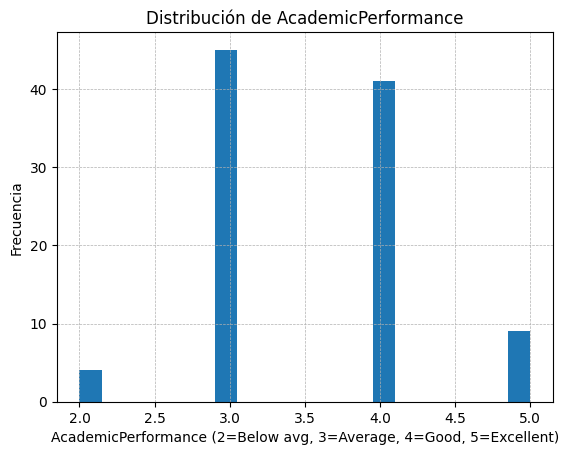

count    99.000000
mean      3.555556
std       0.717453
min       2.000000
25%       3.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: AcademicPerformance, dtype: float64

In [16]:
# Histograma de AcademicPerformance
subset = df_core_clean[["AcademicPerformance"]].dropna()
if subset.empty:
    print("No hay datos v√°lidos para AcademicPerformance")
else:
    plt.figure()
    subset["AcademicPerformance"].plot(kind="hist", bins=20)
    plt.title("Distribuci√≥n de AcademicPerformance")
    plt.xlabel("AcademicPerformance (2=Below avg, 3=Average, 4=Good, 5=Excellent)")
    plt.ylabel("Frecuencia")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.show()
    display(subset["AcademicPerformance"].describe())


# **Gr√°fico 2: Sue√±o vs desempe√±o (dispersi√≥n)**

Ahora contrasto una hip√≥tesis muy intuitiva: ¬øM√°s horas de sue√±o (SleepPerDayHours) se asocian con mejor AcademicPerformance? Para eso uso un scatter. Visualmente puedo detectar tendencia (ascendente/descendente) y posibles no linealidades.
Acompa√±o la figura con el valor de correlaci√≥n de Pearson: no es una prueba causal, pero me da una magnitud y direcci√≥n de la asociaci√≥n.

Qu√© busco:

Tendencia general (¬ølos puntos suben a medida que crece el sue√±o?).

Dispersi√≥n: ¬øla relaci√≥n es fuerte, moderada o d√©bil?

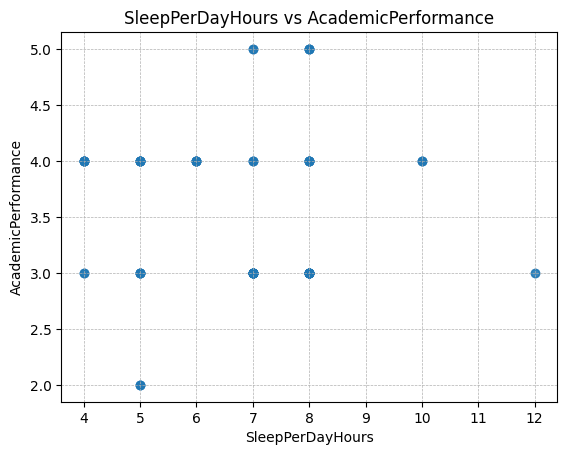

Correlaci√≥n (Pearson): r = 0.045


In [17]:
# Sue√±o vs desempe√±o (scatter + correlaci√≥n)
cols_needed = ["SleepPerDayHours", "AcademicPerformance"]
subset = df_core_clean[cols_needed].dropna()
if subset.empty:
    print("Datos insuficientes para", cols_needed)
else:
    plt.figure()
    plt.scatter(subset["SleepPerDayHours"], subset["AcademicPerformance"], alpha=0.65)
    plt.title("SleepPerDayHours vs AcademicPerformance")
    plt.xlabel("SleepPerDayHours")
    plt.ylabel("AcademicPerformance")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.show()

    r = subset.corr().loc["SleepPerDayHours", "AcademicPerformance"]
    print(f"Correlaci√≥n (Pearson): r = {r:.3f}")


# **Gr√°fico 3: H√°bitos/retos y desempe√±o (boxplot)**

Quiero ver si h√°bitos espec√≠ficos o desaf√≠os acad√©micos se reflejan en el desempe√±o. Un boxplot de AcademicPerformance por TakingNoteInClass (si es categ√≥rica) o por niveles de FaceChallengesToCompleteAcademicTask me permite comparar medianas y variabilidad entre grupos.
Este gr√°fico aporta una lectura ‚Äúpor segmentos‚Äù que el scatter no ofrece: si tomar notas o enfrentar m√°s desaf√≠os distingue claramente los resultados.

Qu√© busco:

Diferencias de mediana entre categor√≠as.

Grupos con mayor dispersi√≥n (potencialmente m√°s inestables).

<Figure size 640x480 with 0 Axes>

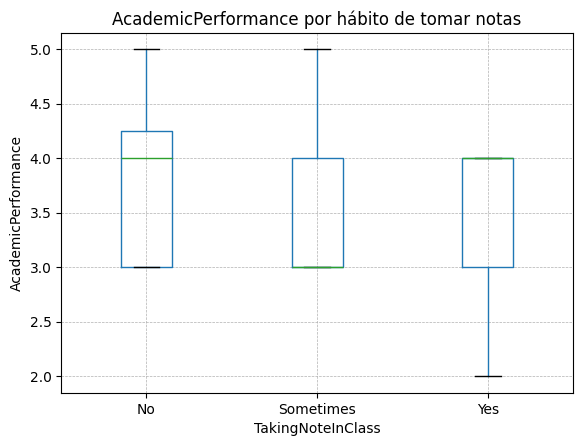

In [18]:
# Boxplot por TakingNoteInClass (1‚Äì3) o por tramos de FaceChallangesToCompleteAcademicTask (1‚Äì3)
if "TakingNoteInClass" in df_core_clean.columns and df_core_clean["TakingNoteInClass"].notna().any():
    sub = df_core_clean[["AcademicPerformance", "TakingNoteInClass"]].dropna()
    if sub.empty:
        print("Datos insuficientes para boxplot por TakingNoteInClass.")
    else:
        labels = {1:"No", 2:"Sometimes", 3:"Yes"}
        sub["NotesGrp"] = sub["TakingNoteInClass"].map(labels).astype("category")
        plt.figure()
        sub.boxplot(column="AcademicPerformance", by="NotesGrp")
        plt.title("AcademicPerformance por h√°bito de tomar notas")
        plt.suptitle("")
        plt.xlabel("TakingNoteInClass")
        plt.ylabel("AcademicPerformance")
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.show()
else:
    print("No se us√≥ TakingNoteInClass; probando por niveles de desaf√≠os‚Ä¶")
    if "FaceChallangesToCompleteAcademicTask" in df_core_clean.columns:
        sub = df_core_clean[["AcademicPerformance","FaceChallangesToCompleteAcademicTask"]].dropna()
        if sub.empty:
            print("Datos insuficientes para boxplot por desaf√≠os.")
        else:
            labels = {1:"No", 2:"Sometimes", 3:"Yes"}
            sub["ChallengesGrp"] = sub["FaceChallangesToCompleteAcademicTask"].map(labels).astype("category")
            plt.figure()
            sub.boxplot(column="AcademicPerformance", by="ChallengesGrp")
            plt.title("AcademicPerformance por nivel de desaf√≠os")
            plt.suptitle("")
            plt.xlabel("FaceChallangesToCompleteAcademicTask")
            plt.ylabel("AcademicPerformance")
            plt.grid(True, linestyle="--", linewidth=0.5)
            plt.show()


# **Gr√°fico 4: Panorama de correlaciones (heatmap num√©rico)**

Construyo un mapa de correlaciones con variables num√©ricas clave (desempe√±o, sue√±o, n√∫mero de amigos, frecuencia de presentaciones, etc.). El heatmap me da una vista de ‚Äúradar‚Äù para detectar pares prometedores que merecen atenci√≥n adicional.
No me quedo con la est√©tica: anoto los 1‚Äì2 coeficientes con mayor |r| para referirme a ellos en hallazgos.

Qu√© busco:

Variables con asociaci√≥n m√°s marcada con AcademicPerformance.

Sorpresas (factores psicosociales con se√±ales m√°s altas de lo esperado).

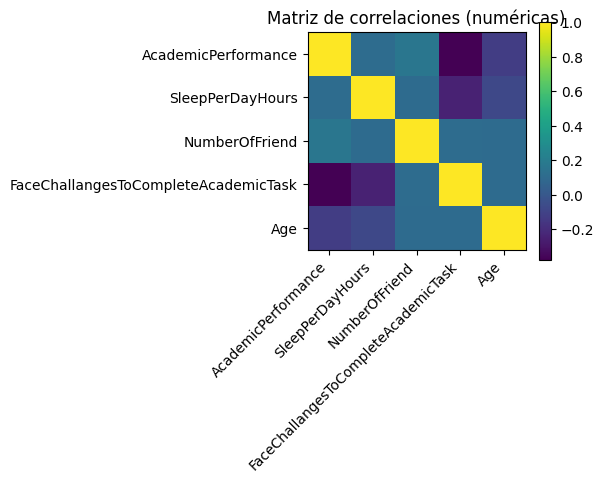

Correlaciones con AcademicPerformance (ordenadas):


AcademicPerformance
AcademicPerformance                              1.000000
NumberOfFriend                                   0.163096
SleepPerDayHours                                 0.110756
Age                                             -0.126220
FaceChallangesToCompleteAcademicTask            -0.374703

In [19]:
# Heatmap de correlaciones
num_candidates = ["AcademicPerformance", "SleepPerDayHours", "NumberOfFriend", "FaceChallangesToCompleteAcademicTask", "Age"]
num_cols = [c for c in num_candidates if c in df_core_clean.columns]
num_df = df_core_clean[num_cols].apply(pd.to_numeric, errors="coerce").dropna()

if num_df.shape[1] < 2 or num_df.empty:
    print("Datos insuficientes para heatmap.")
else:
    corr_mat = num_df.corr()
    plt.figure(figsize=(6,5))
    plt.imshow(corr_mat, interpolation='nearest')
    plt.title("Matriz de correlaciones (num√©ricas)")
    plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
    plt.yticks(range(len(num_cols)), num_cols)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    if "AcademicPerformance" in corr_mat.columns:
        print("Correlaciones con AcademicPerformance (ordenadas):")
        display(corr_mat[["AcademicPerformance"]].sort_values(by="AcademicPerformance", ascending=False))


# **Gr√°fico 5: Rendimiento por grupo (barras por categor√≠a)**

Complemento con un gr√°fico de barras de media de AcademicPerformance por Gender (o alguna otra categor√≠a disponible y relevante). Esto me sirve para detectar brechas o confirmar similitudes entre grupos.
Es un corte simple, pero valioso para el tablero de SenseAI si llega a mostrar ‚Äúcomparativos‚Äù b√°sicos.

Qu√© busco:

Diferencias claras o ausencia de brechas.

Tama√±o de muestra por categor√≠a

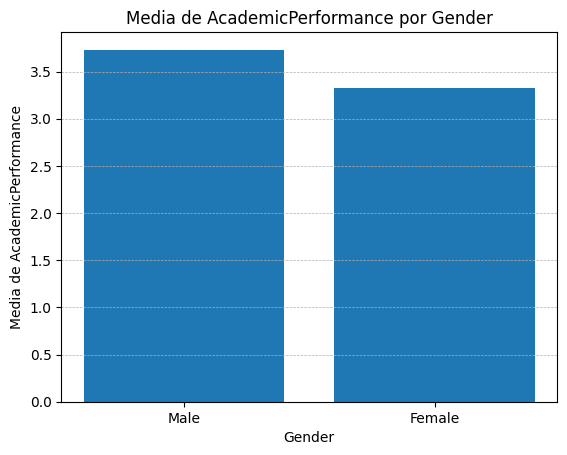

Gender  AcademicPerformance
1    Male             3.732143
0  Female             3.325581

In [20]:
# Media de AcademicPerformance por Gender
if df_context is not None and "Gender" in df_context.columns:
    tmp = pd.concat([df_core_clean[["AcademicPerformance"]], df_context[["Gender"]]], axis=1).dropna()
    if tmp.empty:
        print("Datos insuficientes para barras por Gender.")
    else:
        grp = tmp.groupby("Gender", as_index=False)["AcademicPerformance"].mean().sort_values("AcademicPerformance", ascending=False)
        plt.figure()
        plt.bar(grp["Gender"].astype(str), grp["AcademicPerformance"].values)
        plt.title("Media de AcademicPerformance por Gender")
        plt.xlabel("Gender")
        plt.ylabel("Media de AcademicPerformance")
        plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
        plt.show()
        display(grp)
else:
    print("No est√° disponible la columna Gender en df_context.")


# **Gr√°fico 6: Desaf√≠os acad√©micos en tramos**

Si FaceChallengesToCompleteAcademicTask es num√©rica o ordinal, la agrupo en tramos (bajo/medio/alto) y grafico la media de AcademicPerformance por tramo. As√≠ traduzco un continuo a una lectura m√°s accionable: ¬øa mayor reto reportado, menor desempe√±o promedio?
Esta figura es √∫til para SenseAI porque se parece a una regla: ‚Äúsi el reto sube, acciona recordatorios/microtareas‚Äù.

Qu√© busco:

Patr√≥n mon√≥tono (¬øla media cae cuando el reto sube?).

Se√±ales de umbrales (¬øhay un punto donde el desempe√±o se desploma?).

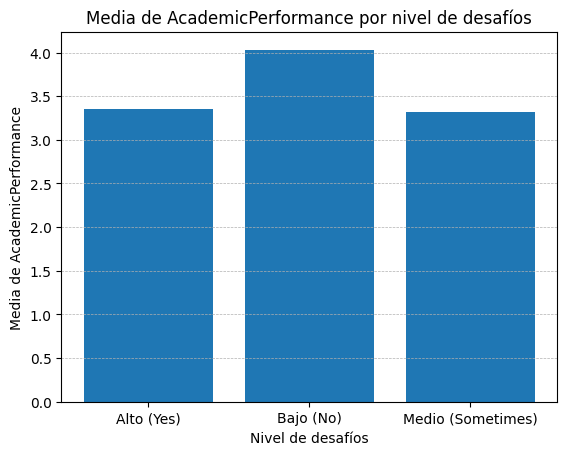

ChallengesGrp  AcademicPerformance
0         Alto (Yes)             3.351351
1          Bajo (No)             4.032258
2  Medio (Sometimes)             3.322581

In [23]:
# Media de desempe√±o por nivel de desaf√≠os
col_y = "AcademicPerformance"
col_x = "FaceChallangesToCompleteAcademicTask"

if col_x in df_core_clean.columns and col_y in df_core_clean.columns:
    tmp = df_core_clean[[col_y, col_x]].dropna().copy()
    if tmp.empty:
        print("Datos insuficientes para tramos de desaf√≠os.")
    else:
        uniq = sorted(tmp[col_x].dropna().unique())
        # Caso A: ya es ordinal 1‚Äì3 (No=1, Sometimes=2, Yes=3) ‚Üí no usamos qcut
        if set(uniq) <= {1, 2, 3} and len(set(uniq)) >= 2:
            label_map = {1: "Bajo (No)", 2: "Medio (Sometimes)", 3: "Alto (Yes)"}
            tmp["ChallengesGrp"] = tmp[col_x].map(label_map)
        else:
            # Caso B: continuo ‚Üí qcut con ajuste de labels al n¬∫ de bins efectivos
            q = 3
            tmp["ChallengesGrp"] = pd.qcut(
                tmp[col_x],
                q=q,
                duplicates="drop"  # si hay empates en cuantiles, reduce bins
            )
            # Ajustar labels al n¬∫ de bins reales
            bins = tmp["ChallengesGrp"].cat.categories
            k = len(bins)  # n¬∫ real de bins
            lbls = ["Bajo", "Medio", "Alto"][:k]
            tmp["ChallengesGrp"] = pd.Categorical(tmp["ChallengesGrp"], categories=bins, ordered=True)
            tmp["ChallengesGrp"] = tmp["ChallengesGrp"].cat.rename_categories(lbls)

        grp = tmp.groupby("ChallengesGrp", as_index=False)[col_y].mean()

        plt.figure()
        plt.bar(grp["ChallengesGrp"].astype(str), grp[col_y].values)
        plt.title(f"Media de {col_y} por nivel de desaf√≠os")
        plt.xlabel("Nivel de desaf√≠os")
        plt.ylabel(f"Media de {col_y}")
        plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
        plt.show()
        display(grp)
else:
    print("No est√°n disponibles las columnas necesarias para este gr√°fico.")


# **Hallazgos**

Aqu√≠ sintetizo 4‚Äì6 hallazgos en bullets, cada uno respaldado por al menos uno de los gr√°ficos previos. Me enfoco en patrones consistentes y anoto anomal√≠as si las veo (valores imposibles, colas raras, categor√≠as diminutas).

Ejemplos que espero ver (ilustrativos):

Asociaci√≥n positiva moderada entre sue√±o y desempe√±o.

Estudiantes que toman notas tienden a mostrar mejores medianas.

A mayor reto acad√©mico reportado, menor media de desempe√±o (tramos).

Correlaciones m√°s altas de lo previsto con alg√∫n factor psicosocial espec√≠fico.

In [24]:
# Hallazgos (borrador)
findings = []

# Distribuci√≥n de desempe√±o
desc = df_core_clean["AcademicPerformance"].dropna().describe() if "AcademicPerformance" in df_core_clean.columns else None
if desc is not None and not desc.empty:
    findings.append(f"- AcademicPerformance: media {desc['mean']:.2f}, mediana {desc['50%']:.2f}, min {desc['min']:.2f}, max {desc['max']:.2f}.")

# Correlaci√≥n sue√±o‚Äìdesempe√±o
if set(["SleepPerDayHours","AcademicPerformance"]).issubset(df_core_clean.columns):
    sub = df_core_clean[["SleepPerDayHours","AcademicPerformance"]].dropna()
    if not sub.empty:
        r = sub.corr().iloc[0,1]
        trend = "positiva" if r > 0.10 else ("negativa" if r < -0.10 else "d√©bil")
        findings.append(f"- Sue√±o vs desempe√±o: r={r:.2f} ({trend}).")

# Notas en clase (si mapeada 1‚Äì3)
if set(["TakingNoteInClass","AcademicPerformance"]).issubset(df_core_clean.columns):
    g = df_core_clean[["TakingNoteInClass","AcademicPerformance"]].dropna()
    if not g.empty and set(g["TakingNoteInClass"].unique()) <= {1,2,3}:
        means = g.groupby("TakingNoteInClass")["AcademicPerformance"].mean().to_dict()
        findings.append(f"- Notas en clase (1=No,2=Sometimes,3=Yes) ‚Üí medias: {means}.")

# Desaf√≠os y desempe√±o
if set(["FaceChallangesToCompleteAcademicTask","AcademicPerformance"]).issubset(df_core_clean.columns):
    h = df_core_clean[["FaceChallangesToCompleteAcademicTask","AcademicPerformance"]].dropna()
    if not h.empty:
        r2 = h.corr().iloc[0,1]
        sign = "menor" if r2 < -0.10 else ("mayor" if r2 > 0.10 else "similar")
        findings.append(f"- M√°s desaf√≠os reportados tienden a asociarse con {sign} desempe√±o (r={r2:.2f}).")

# Amigos y desempe√±o
if set(["NumberOfFriend","AcademicPerformance"]).issubset(df_core_clean.columns):
    k = df_core_clean[["NumberOfFriend","AcademicPerformance"]].dropna()
    if not k.empty:
        r3 = k.corr().iloc[0,1]
        trend3 = "positiva" if r3 > 0.10 else ("negativa" if r3 < -0.10 else "d√©bil")
        findings.append(f"- N¬∫ de amigos vs desempe√±o: r={r3:.2f} ({trend3}).")

print("Hallazgos (borrador):")
print("\n".join(findings) if findings else "(sin hallazgos generados autom√°ticamente)")


Hallazgos (borrador):
- AcademicPerformance: media 3.56, mediana 4.00, min 2.00, max 5.00.
- Sue√±o vs desempe√±o: r=0.05 (d√©bil).
- Notas en clase (1=No,2=Sometimes,3=Yes) ‚Üí medias: {1: 3.8333333333333335, 2: 3.6538461538461537, 3: 3.459016393442623}.
- M√°s desaf√≠os reportados tienden a asociarse con menor desempe√±o (r=-0.38).
- N¬∫ de amigos vs desempe√±o: r=0.16 (positiva).


# **Conclusi√≥n e hip√≥tesis para SenseAI**

Cierro con una hip√≥tesis concreta que el m√≥dulo dashboard/tutor de SenseAI pueda usar. Por ejemplo: ‚ÄúHoras de sue√±o y h√°bito de tomar notas aparecen como se√±ales √∫tiles; cuando el sistema detecte baja de sue√±o o ausencia de notas, debe recomendar microtareas y recordatorios suaves. Si suben los desaf√≠os acad√©micos, SenseAI prioriza rutinas breves (p. ej., t√©cnicas de estudio de 10‚Äì15 min) y sugiere contactar soporte si el patr√≥n persiste‚Äù.
El objetivo es traducir datos a una acci√≥n clara: qu√© mostrar en tarjetas del tablero y qu√© sugerir autom√°ticamente.

Para an√°lisis futuros, anoto dos ampliaciones naturales:

probar otras variables objetivo (p. ej., DepressionStatus con proporciones por bins de sue√±o), y explorar interacciones simples (sue√±o √ó tomar notas).

In [25]:
# Conclusi√≥n/Hip√≥tesis (relaci√≥n con SenseAI)
def fmt(x):
    return "‚Äî" if x is None or (isinstance(x, float) and np.isnan(x)) else f"{x:.2f}"

r_sleep = np.nan
sub = df_core_clean[["SleepPerDayHours","AcademicPerformance"]].dropna() \
      if set(["SleepPerDayHours","AcademicPerformance"]).issubset(df_core_clean.columns) else None
if sub is not None and not sub.empty:
    r_sleep = sub.corr().iloc[0,1]

text = f"""
Conclusi√≥n/Hip√≥tesis (borrador):
- Se observa r={fmt(r_sleep)} entre horas de sue√±o y desempe√±o; conviene monitorear SleepPerDayHours en el tablero.
- H√°bitos (TakingNoteInClass) y desaf√≠os (FaceChallangesToCompleteAcademicTask) muestran patrones que diferencian el rendimiento.

Para SenseAI:
- Si bajan las horas de sue√±o o suben los desaf√≠os, el tutor sugiere microtareas de 10‚Äì15 min y recordatorios de higiene del sue√±o.
- Si TakingNoteInClass es bajo, recomendar t√©cnicas de notas (Cornell, bullet points) y medir adopci√≥n la semana siguiente.
"""
print(text.strip())


Conclusi√≥n/Hip√≥tesis (borrador):
- Se observa r=0.05 entre horas de sue√±o y desempe√±o; conviene monitorear SleepPerDayHours en el tablero.
- H√°bitos (TakingNoteInClass) y desaf√≠os (FaceChallangesToCompleteAcademicTask) muestran patrones que diferencian el rendimiento.

Para SenseAI:
- Si bajan las horas de sue√±o o suben los desaf√≠os, el tutor sugiere microtareas de 10‚Äì15 min y recordatorios de higiene del sue√±o.
- Si TakingNoteInClass es bajo, recomendar t√©cnicas de notas (Cornell, bullet points) y medir adopci√≥n la semana siguiente.


# **Exportaci√≥n de reporte**

In [27]:
# Guardar reporte
from pathlib import Path

REPORT_PATH = Path("/content/EDA_Psychosocial_SenseAI_Resumen.txt")
content = []
content.append("EDA ‚Äî Psychosocial Dimensions of Student Life (SenseAI)")
content.append(f"Figuras generadas en el cuaderno. Resumen de hallazgos:")
content.extend(findings if 'findings' in globals() and findings else ["(sin hallazgos autom√°ticos)"])

with open(REPORT_PATH, "w", encoding="utf-8") as f:
    f.write("\n".join(content))

print(f"üìÑ Reporte guardado en: {REPORT_PATH}")

üìÑ Reporte guardado en: /content/EDA_Psychosocial_SenseAI_Resumen.txt
